In [1]:
# Data Preprocessing: Create Mel-Frequency Spectrograms from audio files of 1s in length

from pydub import AudioSegment 
from pydub.utils import make_chunks
import librosa  
import os

file_path_DEFECT = "/Users/johanvekeman/Documents/Datasets/Home_Assignment/Defect" # 180 files
file_path_SOUND = "/Users/johanvekeman/Documents/Datasets/Home_Assignment/Sound" # 130 files

def MelFreqSpec(file_path):
    Spectrograms=[]
    all_audio_files = os.listdir(file_path )
    # print(all_audio_files)
    for audio_file in all_audio_files:
        audio, sr = librosa.load(file_path + '/' + audio_file, 22000)
        Spectrogram=librosa.feature.melspectrogram(audio)
        Spectrograms.append(Spectrogram)  
    return Spectrograms # List of Mel-Frequency Cepstral Coefficients 


def label(samples, yes_no): 
    defect=[]
    for i in range(samples): 
        defect.append(yes_no)
    return defect

DEFECT=MelFreqSpec(file_path_DEFECT)
SOUND=MelFreqSpec(file_path_SOUND)

YES=label(len(DEFECT), 1) # Defect
NO=label(len(SOUND), 0) # No Defect



In [10]:
Spectrograms=DEFECT+SOUND
Inference=YES+NO

In [11]:
print('height x width =', Spectrograms[0].shape)
height=Spectrograms[0].shape[0]
width=Spectrograms[0].shape[1]
print(len(Spectrograms))
length=len(Spectrograms)
print(len(DEFECT))
print(len(SOUND))

height x width = (128, 43)
310
180
130


[Text(0.5, 1.0, 'Mel-frequency spectogram')]

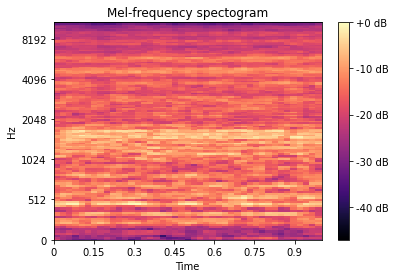

In [12]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

number=30
sr=22000

#Displaying Mel-frequency spectrogram for sound weld:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(SOUND[number], ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=sr/2, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectogram')


[Text(0.5, 1.0, 'Mel-frequency spectogram')]

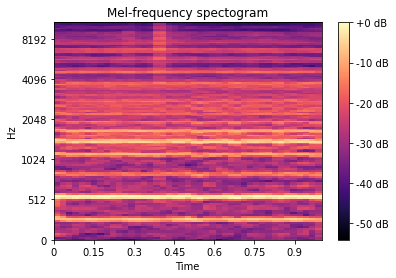

In [13]:
# Displaying Mel-frequency spectrogram for weld with defect:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(DEFECT[number], ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=sr/2, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectogram')


In [15]:
# From list to numpy array
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
import tensorflow
from tensorflow.keras.utils import to_categorical

X=np.array(Spectrograms)
X=X.reshape(length, height*width)
#scaler=MinMaxScaler()
#scaler=StandardScaler()
#scaler=RobustScaler()
#X=scaler.fit_transform(X)
X=X.reshape(length,height,width)

Inference=np.array(Inference)
le=LabelEncoder()
y=to_categorical(le.fit_transform(Inference))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.32, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,  test_size=0.50, random_state=42)

X_train=X_train.astype('float32')
X_val=X_val.astype('float32')
X_test=X_test.astype('float32')

In [16]:
# Verification datasets
print (X_train[0])
print(y_train[0])
print(len(y_train))
print(len(y_val))
print(len(y_test))


[[2.0160356e-03 5.3210481e-04 4.9169965e-05 ... 5.5934407e-04
  4.9177662e-04 5.6859670e-04]
 [1.9538633e-03 7.3377759e-04 1.6977977e-04 ... 3.5473754e-04
  5.0403189e-04 1.9174650e-04]
 [1.1057546e-03 3.2148213e-04 5.7338915e-05 ... 1.0063864e-03
  1.1200387e-03 2.2052843e-04]
 ...
 [2.5248810e-04 2.7160294e-04 2.1652329e-04 ... 1.9244213e-03
  4.9741887e-03 5.2684406e-03]
 [1.2938629e-04 1.1126477e-04 9.9933968e-05 ... 9.1913028e-04
  2.4709550e-03 2.2354040e-03]
 [9.5645455e-06 8.2700290e-06 9.4845109e-06 ... 4.9580074e-05
  1.2159053e-04 1.4011718e-04]]
[0. 1.]
210
50
50


In [19]:
# The shape of X_train in now (210, 128, 43) and for X_val/X_test (50,128,43) with the image (128x43).
# The input shape for a CNN in Tensorflow should be in the format (batch, height, width, channels).

X_train=X_train.reshape(X_train.shape[0], height, width, 1)
X_val=X_val.reshape(X_val.shape[0], height, width, 1)
X_test=X_test.reshape(X_test.shape[0], height, width, 1)


In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout, LayerNormalization
import matplotlib.pyplot as plt

model = models.Sequential()

#model.add(layers.LayerNormalization())

model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(height, width, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(layers.LayerNormalization())

model.add(layers.Conv2D(8, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(layers.LayerNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) # activation with sigmoid if 1 neuron in final layer

model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 127, 42, 8)        40        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 21, 8)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 21, 8)         0         
_________________________________________________________________
layer_normalization_6 (Layer (None, 63, 21, 8)         16        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 20, 8)         264       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 10, 8)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 10, 8)        

In [22]:
from tensorflow.keras.optimizers import RMSprop, Adam
model.compile(loss='categorical_crossentropy', # binary_crossentropy if sigmoid is used
              optimizer='Adam', # RMSprop'(learning_rate=0.1), #0.001 
              metrics='accuracy')

history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))

2022-02-03 21:42:42.159241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-03 21:42:42.159432: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-03 21:42:42.348814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40
7/7 [==============================] - ETA: 0s - loss: 0.7818 - accuracy: 0.5286

2022-02-03 21:42:44.327895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 306ms/step - loss: 0.7818 - accuracy: 0.5286 - val_loss: 0.7343 - val_accuracy: 0.5600
Epoch 2/40
7/7 [==============================] - 2s 292ms/step - loss: 0.6758 - accuracy: 0.6286 - val_loss: 0.5403 - val_accuracy: 0.7600
Epoch 3/40
7/7 [==============================] - 2s 295ms/step - loss: 0.6071 - accuracy: 0.6524 - val_loss: 0.4418 - val_accuracy: 0.8000
Epoch 4/40
7/7 [==============================] - 2s 282ms/step - loss: 0.5128 - accuracy: 0.7571 - val_loss: 0.3730 - val_accuracy: 0.8600
Epoch 5/40
7/7 [==============================] - 2s 286ms/step - loss: 0.4946 - accuracy: 0.7905 - val_loss: 0.4840 - val_accuracy: 0.7200
Epoch 6/40
7/7 [==============================] - 2s 287ms/step - loss: 0.4800 - accuracy: 0.7476 - val_loss: 0.3936 - val_accuracy: 0.8600
Epoch 7/40
7/7 [==============================] - 2s 292ms/step - loss: 0.3830 - accuracy: 0.8095 - val_loss: 0.2864 - val_accuracy: 0.8800
Epoch 8/40
7/7 [===============

2/2 - 0s - loss: 0.1300 - accuracy: 0.9800


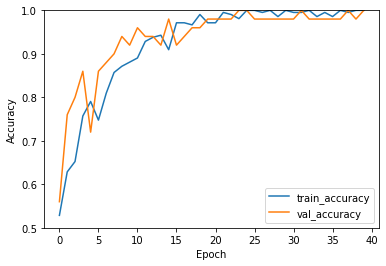

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.1300 - accuracy: 0.9800


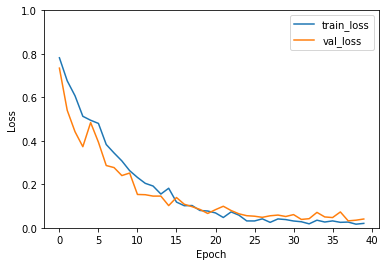

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Testen van het CNN

y_pred = np.argmax(model.predict(X_test), axis=-1)
print('Predicted values: \n', y_pred)
y_true = np.argmax(y_test, axis=-1)
print('True values: \n', y_true)

2022-02-03 21:44:38.081528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Predicted values: 
 [1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0
 0 1 1 1 1 0 1 1 1 0 1 1 0]
True values: 
 [1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0
 0 1 1 1 1 0 1 1 1 0 1 1 0]


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Testen van het CNN

print("Accuracy score : %.1f"%(accuracy_score(y_true, y_pred) * 100)) 
print(classification_report(y_true, y_pred))
cf_matrix=confusion_matrix(y_true, y_pred)
print(cf_matrix)

Accuracy score : 98.0
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.97      1.00      0.99        33

    accuracy                           0.98        50
   macro avg       0.99      0.97      0.98        50
weighted avg       0.98      0.98      0.98        50

[[16  1]
 [ 0 33]]


Definitions:
accuracy: Hoeveel juist geclassificeerd: 
precision: Hoeveel van de voorspellingen waren juist geclassificeerd: 
recall: Hoeveel van elke klasse juist geclassificeerd: 
f1-score:

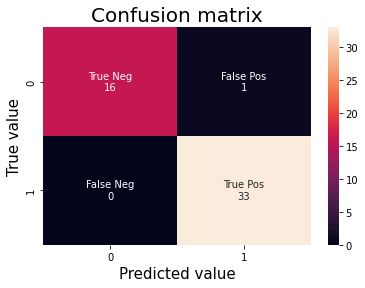

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='')

plt.title('Confusion matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted value', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True value', fontsize = 15) # y-axis label with fontsize 15

plt.show()

In [35]:
audio_sample = 3
y_probability = model.predict(X_test[[audio_sample]])
print(y_probability)
prediction = np.argmax(model.predict(X_test[[audio_sample]]), axis=-1)
print (prediction)

[[0.9939091  0.00609088]]
[0]


In [32]:
model.save('./my_model.h5')